In [1]:
cd /kaggle/input/dance-form/dataset/

/kaggle/input/dance-form/dataset


In [2]:
ls

test/  test.csv  train/  train.csv


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Model, Sequential
import pandas as pd
df=pd.read_csv("train.csv")
classes_list = df['target'].unique().tolist()
print(classes_list)
print(df.target.value_counts())
df.head()

['manipuri', 'bharatanatyam', 'odissi', 'kathakali', 'kathak', 'sattriya', 'kuchipudi', 'mohiniyattam']
mohiniyattam     50
odissi           49
kathakali        47
bharatanatyam    47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64


,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [4]:
df_test =pd.read_csv("test.csv")
df_test.head()

,Image
0,508.jpg
1,246.jpg
2,473.jpg
3,485.jpg
4,128.jpg


Data Augmentation:-
Image Data Generator changes the differnt size images to the input size.
Normalize images while loading them.
Create augmented images in the memory.
Label them based on the labels in the dataframe (since we are using flow from dataframe)

In [5]:
datagen=ImageDataGenerator(rescale=1./255,shear_range=0.20,
                                   zoom_range=0.20,validation_split=0.2,
                                   horizontal_flip=True)

train_generator=datagen.flow_from_dataframe(dataframe=df, subset="training",has_ext=True,
                                            directory="train", interpolation="nearest",validate_filenames=False,
                                            x_col="Image", y_col="target",color_mode="rgb",shuffle=True, classes = classes_list,
                                            class_mode="categorical", target_size=(224,224), batch_size=32)

valid_generator=datagen.flow_from_dataframe(dataframe=df, subset="validation",has_ext=True,
                                            directory="train", interpolation="nearest",validate_filenames=False,
                                            x_col="Image", y_col="target",color_mode="rgb",shuffle=True, classes = classes_list,
                                            class_mode="categorical", target_size=(224,224), batch_size=32)


Found 292 non-validated image filenames belonging to 8 classes.
Found 72 non-validated image filenames belonging to 8 classes.


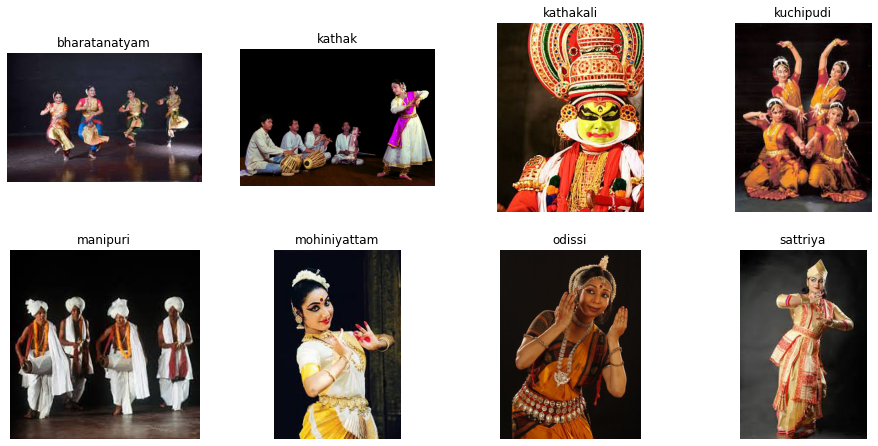

In [6]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os
nrows = 4
ncols = 4

pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=4

next_pix = [(os.path.join('train', fname) , name)
                for fname,name in (zip(df.groupby('target').first().Image.values,df.groupby('target').first().index))]

for i, img_path in enumerate(next_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path[0])
    plt.imshow(img)
    plt.title(img_path[1])

plt.show()


In [7]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

IMAGE_SIZE = [224, 224]
# add preprocessing layer to the fromt of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #pooling='max')

58892288/58889256 [==============================] - 0s 0us/step


VGG-19 is a convolutional neural network which is 19 layers deep. It's pretrained version of the network has trained on more than a million images from the ImageNet database. This network is trained on images with an input size of 224-by-224. By adding few more layers to this pretrained model, we can use it for classification of the various dance forms. As, pretrained model has already extracted out the edges and important features from millions of images, so it can classify images with much higher accuracy.

In [8]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [9]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.15)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.15)(x)
prediction = Dense(8, activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Set a Learning Rate Annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [14]:
history = model.fit_generator(train_generator,
        validation_data = valid_generator,
        epochs = 30,
        steps_per_epoch = len(train_generator),
        validation_steps = len(valid_generator),
        callbacks = [learning_rate_reduction]
)

Epoch 1/30
10/10 [==============================] - 7s 691ms/step - loss: 9.8068 - accuracy: 0.1610 - val_loss: 5.4363 - val_accuracy: 0.1528 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - 6s 628ms/step - loss: 3.3963 - accuracy: 0.2740 - val_loss: 2.0569 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - 7s 679ms/step - loss: 1.9765 - accuracy: 0.3596 - val_loss: 1.6478 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 4/30
10/10 [==============================] - 6s 616ms/step - loss: 1.4171 - accuracy: 0.4932 - val_loss: 1.5002 - val_accuracy: 0.4583 - lr: 0.0010
Epoch 5/30
10/10 [==============================] - 6s 611ms/step - loss: 1.0815 - accuracy: 0.6336 - val_loss: 1.5338 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 6/30
10/10 [==============================] - 7s 666ms/step - loss: 0.8555 - accuracy: 0.7329 - val_loss: 1.3464 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 7/30
10/10 [==============================] - 6s 612ms/step - lo

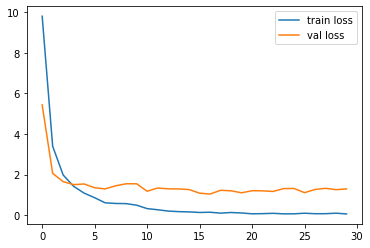

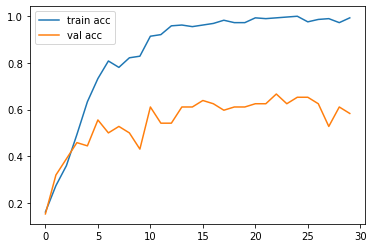

In [15]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [20]:
cd /kaggle/input/inception/

/kaggle/input/inception


In [21]:
ls

inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [36]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
local_weights_file = '/kaggle/input/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [37]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (8, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])


In [32]:
cd /kaggle/input/dance-form/dataset/

/kaggle/input/dance-form/dataset


In [40]:
history = model.fit(
            train_generator,
            validation_data = valid_generator,
            steps_per_epoch = len(train_generator),
            epochs = 30,
            validation_steps = len(valid_generator),
            verbose = 2)

Epoch 1/30
10/10 - 6s - loss: 1.0620 - accuracy: 0.6541 - val_loss: 2.0970 - val_accuracy: 0.3750
Epoch 2/30
10/10 - 6s - loss: 0.9211 - accuracy: 0.7500 - val_loss: 3.4755 - val_accuracy: 0.2917
Epoch 3/30
10/10 - 7s - loss: 0.6868 - accuracy: 0.8082 - val_loss: 1.5415 - val_accuracy: 0.4861
Epoch 4/30
10/10 - 6s - loss: 0.2595 - accuracy: 0.9384 - val_loss: 1.4861 - val_accuracy: 0.5694
Epoch 5/30
10/10 - 7s - loss: 0.3327 - accuracy: 0.8973 - val_loss: 1.4780 - val_accuracy: 0.5556
Epoch 6/30
10/10 - 7s - loss: 0.2253 - accuracy: 0.9452 - val_loss: 2.6227 - val_accuracy: 0.4583
Epoch 7/30
10/10 - 7s - loss: 0.4368 - accuracy: 0.8664 - val_loss: 1.5204 - val_accuracy: 0.5417
Epoch 8/30
10/10 - 6s - loss: 0.1974 - accuracy: 0.9452 - val_loss: 1.3958 - val_accuracy: 0.5833
Epoch 9/30
10/10 - 6s - loss: 0.2018 - accuracy: 0.9384 - val_loss: 1.8025 - val_accuracy: 0.5417
Epoch 10/30
10/10 - 6s - loss: 0.0229 - accuracy: 0.9897 - val_loss: 1.6395 - val_accuracy: 0.5833
Epoch 11/30
10/10 -

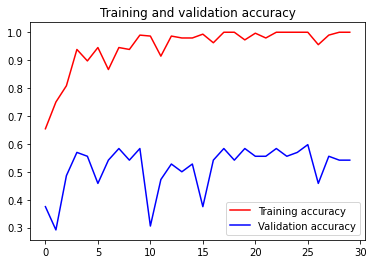

<Figure size 432x288 with 0 Axes>

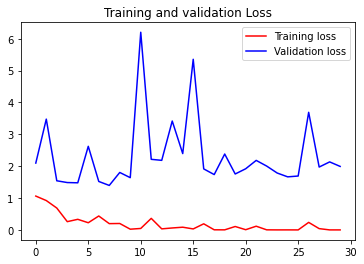

<Figure size 432x288 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [44]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [45]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [47]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [48]:
prediction_layer = tf.keras.layers.Dense(1)

In [49]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
base_learning_rate = 0.0001
model.compile(optimizer=tf.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [50]:
len(model.trainable_variables)

2

In [52]:
initial_epochs = 10
validation_steps=20

In [ ]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=valid_generator)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()